<a href="https://colab.research.google.com/github/StephaneWamba/Machine-Learning-Finance/blob/main/How_to_use_a_pretrained_model_to_do_sentiment_analysis_on_scraped_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Sentiment Analysis of CNBC Headlines with a pretrained model, example of FinBERT**

This notebook demonstrates how to perform sentiment analysis on financial news headlines from CNBC.com using the `ProsusAI/finbert` model, a fine-tuned version of BERT specifically for financial texts. The project aims to categorize headlines into three sentiments: positive, negative, and neutral. This exercise is educational and showcases the practical application of NLP in finance.

## Overview
- **Scrape CNBC Headlines**: Collect headlines using BeautifulSoup.
- **Sentiment Analysis**: Use `ProsusAI/finbert` to predict the sentiment of each headline.
- **Analysis and Visualization**: Analyze the distribution of sentiments and visualize the results.


## Setup and Dependencies

First, let's install and import the necessary libraries for this project.


In [13]:
# Install necessary libraries
!pip install requests beautifulsoup4 torch transformers matplotlib pandas

# Import libraries
import requests
from bs4 import BeautifulSoup
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import softmax
import pandas as pd
import matplotlib.pyplot as plt


## Web Scraping CNBC Headlines

We'll scrape the CNBC website for headlines. Specifically, we're interested in headlines within elements having class names 'Card-title' and 'TrendingNowItem-title'.


In [38]:
# Function to scrape CNBC for headlines
def scrape_cnbc_headlines():
    base_url = "https://www.cnbc.com/investing"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(base_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all navigation links
    nav_links = soup.find_all(class_='PageHeader-navLink')
    nav_urls = [link['href'] if link['href'].startswith('http') else 'https://www.cnbc.com' + link['href'] for link in nav_links]

    # Initialize a list to store headlines
    all_headlines = []

    # Iterate through each navigation link URL
    for url in nav_urls:
        print(url)
        # Make a request to the navigation link page
        response = requests.get(url, headers=headers)
        page_soup = BeautifulSoup(response.content, 'html.parser')

        # Find elements by class names for headlines within the nav link pages
        card_titles = page_soup.find_all(class_='Card-title')
        trending_titles = page_soup.find_all(class_='TrendingNowItem-title')

        # Extract text and add to the list of all headlines
        headlines = [title.get_text().strip() for title in card_titles + trending_titles]
        all_headlines.extend(headlines)

    return all_headlines


headlines = scrape_cnbc_headlines()
print(headlines[:5])  # Display first 5 headlines


https://www.cnbc.com/invest-in-you/
https://www.cnbc.com/personal-finance/
https://www.cnbc.com/options-action/
https://www.cnbc.com/etf-street/
https://www.cnbc.com/earnings/
https://www.cnbc.com/trader-talk/
['Should you be worried about your money, your bank or the U.S. banking system? Experts weigh in', 'Buy everything with credit cards — provided you meet 1 condition', 'Missing tax forms can delay your refund. How to know which ones you need', 'Suzy Welch: Tips to recession-proof your job and avoid getting laid off', 'Employers can use this retirement perk as a ‘stepping stone’ to a 401(k)']


## Sentiment Analysis with FinBERT

Next, we'll load the `ProsusAI/finbert` model and use it to predict the sentiment of each scraped headline. The ProsusAI/finbert model is a variant of the BERT (Bidirectional Encoder Representations from Transformers) model that has been specifically fine-tuned for sentiment analysis in the financial domain.


In [42]:
# Function to predict sentiment of headlines
def predict_sentiment(headlines):
    model_name = "ProsusAI/finbert"
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    sentiments = []
    for headline in headlines:
        inputs = tokenizer(headline, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        probabilities = softmax(outputs.logits, dim=1)
        predicted_class = probabilities.argmax().item()
        # Map model output to sentiment labels
        sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
        sentiments.append((headline, sentiment_map[predicted_class]))
    return sentiments

sentiments = predict_sentiment(headlines)
print(sentiments[:5])


[('Should you be worried about your money, your bank or the U.S. banking system? Experts weigh in', 'positive'), ('Buy everything with credit cards — provided you meet 1 condition', 'positive'), ('Missing tax forms can delay your refund. How to know which ones you need', 'positive'), ('Suzy Welch: Tips to recession-proof your job and avoid getting laid off', 'positive'), ('Employers can use this retirement perk as a ‘stepping stone’ to a 401(k)', 'negative')]


## Analysis and Visualization

After predicting sentiments, let's analyze the distribution of sentiments among the CNBC headlines and visualize the results with a bar chart.


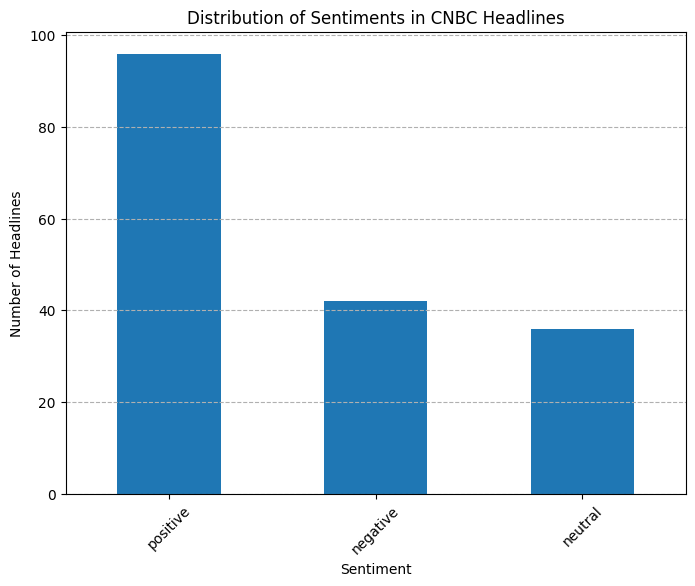

In [41]:
# Analyze and plot the distribution of sentiments
def analyze_and_plot(sentiments):
    df = pd.DataFrame(sentiments, columns=['Headline', 'Sentiment'])
    sentiment_counts = df['Sentiment'].value_counts()

    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar')
    plt.title('Distribution of Sentiments in CNBC Headlines')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Headlines')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

analyze_and_plot(sentiments)
